In [238]:
import asyncio
import ccxt
# import ccxt.async_support as ccxt # link against the asynchronous version of ccxt
import pandas as pd
import os
import datetime
import pandas as pd
from ccxt.base.exchange import Exchange
import numpy as np
import hvplot.pandas
from sklearn.decomposition import PCA
import plotly.express as px

## Kraken Cryptos features (Part A)

In [239]:
url ="https://coinmarketcap.com/all/views/all/"
coinmarket_url_df= pd.read_html(url)
mc_df=coinmarket_url_df[2:]
mc_df=mc_df[0]
mc_df.dtypes
mc_df['market_cap']=mc_df['Market Cap'].str.replace('$', '')
mc_df['market_cap']=mc_df['market_cap'].str.replace(',', '').astype('float')
mc_df['price']=mc_df['Price'].str.replace('$', '')
mc_df['price']=mc_df['price'].str.replace(',', '').astype('float')
mc_df['circulating_suppy']=mc_df.market_cap/mc_df.price
mc_df['volume_24h']=mc_df['Volume (24h)'].str.replace('$', '')
mc_df['volume_24h']=mc_df['volume_24h'].str.replace(',', '').astype('float')
cm_crypto_features_df=mc_df.drop(columns=['Name','Rank','Market Cap','Price','Circulating Supply','Volume (24h)','% 1h','% 24h','% 7d','Unnamed: 10',],axis=1)
cm_crypto_features_df.tail()

,Symbol,market_cap,price,circulating_suppy,volume_24h
195,NEX,18324888.0,0.781692,2.344259e+07,67825.0
196,CELR,18189248.0,0.004806,3.784696e+09,6649725.0
197,KAN,18104473.0,0.002846,6.361375e+09,1640905.0
198,IGNIS,17995944.0,0.023643,7.611532e+08,1328741.0
199,MBL,17829076.0,0.002144,8.315800e+09,9872937.0


## Create list of tickers to pull data from Kraken

In [240]:
cm_crypto_features_df['ticker']=cm_crypto_features_df.Symbol+'/USD'
tickers=cm_crypto_features_df.ticker.values.tolist()
len(tickers)

200

## Import data from Kraken

In [241]:
# Import environment variables
KRAKEN_PUBLIC_KEY = os.getenv('KRAKEN_PUBLIC_API_KEY')
KRAKEN_SECRET_KEY = os.getenv('KRAKEN_SECRET_API_KEY')

In [242]:
#Pull data from kraken
# Set the public and private keys for the API
exchange = ccxt.kraken({
    'apiKey': KRAKEN_PUBLIC_KEY,
    'secret': KRAKEN_SECRET_KEY,
})
since = exchange.parse8601('2020-01-01T00:00:00z')
cols=['time','open','high','low','close','volume','ticker']
symbols = tickers
timeframe='1d'
crypto_returns_df1= []
for i in symbols:
    try:
        price_batch = pd.DataFrame(exchange.fetchOHLCV(i,timeframe, since, params = {}))
        price_batch[6]=i
        price_batch[0] = pd.to_datetime(price_batch[0], unit="ms")
        crypto_returns_df1.append(price_batch)
    except Exception:
        cryptos_historic_df_kraken = pd.concat(crypto_returns_df1)
        cryptos_historic_df_kraken.columns=cols

In [243]:
cryptos_historic_df_kraken.head()

,time,open,high,low,close,volume,ticker
0,2020-01-01,7168.3,7235.0,7150.0,7174.4,1718.343670,BTC/USD
1,2020-01-02,7174.4,7185.8,6915.0,6942.3,3781.585794,BTC/USD
2,2020-01-03,6942.3,7397.3,6860.0,7334.8,7378.843309,BTC/USD
3,2020-01-04,7334.8,7396.4,7260.1,7350.2,2739.261173,BTC/USD
4,2020-01-05,7350.2,7493.3,7301.1,7346.9,2673.471636,BTC/USD


In [244]:
#Full df of cryptos
crypto_close_kraken= cryptos_historic_df_kraken.drop(columns=['open','high','low','volume'],axis=1)
crypto_close_kraken= crypto_close_kraken.pivot_table(index='time', columns='ticker', values='close', aggfunc='mean')
len(crypto_close_kraken.columns)

36

In [245]:
#cryptos df with same lenght of historic data
filter_cryptos=pd.DataFrame(len(crypto_close_kraken) - crypto_close_kraken.count())
filter_cryptos=list(filter_cryptos[filter_cryptos[0]==0].index.values)
len(filter_cryptos)

29

In [318]:
crypto_close_df=crypto_close_kraken[filter_cryptos]
# crypto_close_df=crypto_close_df.drop(['BTC/USD'], axis=1)
crypto_close_df

ticker,ADA/USD,ATOM/USD,BAT/USD,BCH/USD,BTC/USD,DAI/USD,DASH/USD,DOGE/USD,EOS/USD,ETC/USD,...,QTUM/USD,REP/USD,SC/USD,USDT/USD,WAVES/USD,XLM/USD,XMR/USD,XRP/USD,XTZ/USD,ZEC/USD
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.033411,4.3701,0.19543,203.5,7174.4,0.99482,41.811,0.002007,2.5788,4.489,...,1.59885,8.654,0.00130,0.9970,1.0457,0.045192,45.62,0.19269,1.3689,27.96
2020-01-02,0.032693,4.0624,0.18144,195.4,6942.3,0.99760,39.839,0.001991,2.4490,4.238,...,1.50101,8.477,0.00125,0.9970,0.9433,0.043520,45.28,0.18682,1.2300,26.97
2020-01-03,0.033847,4.2398,0.18645,221.6,7334.8,0.99750,43.726,0.002449,2.6325,4.562,...,1.61882,8.822,0.00131,0.9984,0.9489,0.045310,50.72,0.19286,1.2769,28.37
2020-01-04,0.034301,4.2315,0.18831,224.5,7350.2,0.99511,46.026,0.002060,2.6407,4.758,...,1.64227,9.090,0.00134,0.9979,0.9470,0.045513,50.37,0.19269,1.2541,29.88
2020-01-05,0.034487,4.1700,0.18706,222.6,7346.9,0.99781,51.055,0.002074,2.6777,4.878,...,1.61740,9.344,0.00135,0.9991,0.8914,0.045264,53.44,0.19443,1.2479,30.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-12,0.127061,4.0196,0.25865,237.4,9300.0,1.01989,72.000,0.003649,2.6166,6.471,...,2.04328,19.484,0.00348,1.0001,1.2124,0.095343,69.23,0.20105,2.8235,58.50
2020-07-13,0.124305,3.8651,0.26219,231.8,9236.2,1.01576,71.801,0.003164,2.5513,6.308,...,2.21458,18.727,0.00333,0.9992,1.1775,0.090380,69.16,0.19859,2.9037,61.47
2020-07-14,0.132186,3.9534,0.26323,229.9,9252.2,1.01549,72.001,0.003301,2.5618,6.323,...,2.35655,20.065,0.00335,0.9998,1.3094,0.091911,67.99,0.19890,2.9600,61.93


## Crypto Historic Returns

In [247]:
# Calculate Daily Returns 
crypto_returns = (crypto_close_df - crypto_close_df.shift(1)) / crypto_close_df.shift(1)
crypto_returns = crypto_returns.dropna()
crypto_returns.head()

ticker,ADA/USD,ATOM/USD,BAT/USD,BCH/USD,BTC/USD,DAI/USD,DASH/USD,DOGE/USD,EOS/USD,ETC/USD,...,QTUM/USD,REP/USD,SC/USD,USDT/USD,WAVES/USD,XLM/USD,XMR/USD,XRP/USD,XTZ/USD,ZEC/USD
time,,,,,,,,,,,,,,,,,,,,,
2020-01-02,-0.021490,-0.070410,-0.071586,-0.039803,-0.032351,0.002794,-0.047165,-0.007924,-0.050333,-0.055914,...,-0.061194,-0.020453,-0.038462,0.000000,-0.097925,-0.036998,-0.007453,-0.030463,-0.101468,-0.035408
2020-01-03,0.035298,0.043669,0.027612,0.134084,0.056537,-0.000100,0.097568,0.230483,0.074929,0.076451,...,0.078487,0.040698,0.048000,0.001404,0.005937,0.041131,0.120141,0.032331,0.038130,0.051910
2020-01-04,0.013413,-0.001958,0.009976,0.013087,0.002100,-0.002396,0.052600,-0.159059,0.003115,0.042964,...,0.014486,0.030379,0.022901,-0.000501,-0.002002,0.004480,-0.006901,-0.000881,-0.017856,0.053225
2020-01-05,0.005423,-0.014534,-0.006638,-0.008463,-0.000449,0.002713,0.109264,0.006797,0.014011,0.025221,...,-0.015144,0.027943,0.007463,0.001203,-0.058712,-0.005471,0.060949,0.009030,-0.004944,0.024096
2020-01-06,0.083858,-0.015228,0.014755,0.097035,0.055860,-0.000712,0.111194,0.029511,0.065205,0.029315,...,0.069197,0.032962,0.037037,0.001301,0.003365,0.116914,0.102171,0.148485,0.042792,0.067320


In [248]:
# Annualized Standard Deviations
annualized_std = crypto_returns.std()* np.sqrt(252)
annualized_std = annualized_std.to_frame()
annualized_std.columns=['SD']
annualized_std.head()

,SD
ticker,
ADA/USD,1.000679
ATOM/USD,0.948218
BAT/USD,0.959464
BCH/USD,1.024802
BTC/USD,0.736951


In [252]:
# Annualzied Sharpe Ratios
sharpe_ratios = (crypto_returns.mean() * 252) / (crypto_returns.std() * np.sqrt(252))
sharpe_ratios = sharpe_ratios.to_frame()
sharpe_ratios.columns = ['sharpe_ratio']
sharpe_ratios.head()

,sharpe_ratio
ticker,
ADA/USD,2.231982
ATOM/USD,0.402649
BAT/USD,0.912738
BCH/USD,0.673800
BTC/USD,0.828805


## Kraken Cryptos features (Part B)

In [253]:
cm_crypto_features_df['ticker']=cm_crypto_features_df.Symbol+'/USD'
crypto_features_df=cm_crypto_features_df.set_index('ticker')
crypto_features_df=crypto_features_df.drop('Symbol',axis=1)

In [254]:
left_merge=crypto_features_df.join(sharpe_ratios,how='inner')
crypto_features_df=left_merge.join(annualized_std,how='inner')
crypto_features_df.head()

,market_cap,price,circulating_suppy,volume_24h,sharpe_ratio,SD
ticker,,,,,,
BTC/USD,1.687175e+11,9152.150000,1.843474e+07,1.576724e+10,0.828805,0.736951
ETH/USD,2.610287e+10,233.510000,1.117848e+08,6.188149e+09,1.309633,0.936119
USDT/USD,9.194532e+09,1.000000,9.194532e+09,2.058645e+10,0.142830,0.025620
XRP/USD,8.576460e+09,0.193784,4.425783e+10,1.059298e+09,0.406411,0.757499
BCH/USD,4.142723e+09,224.370000,1.846380e+07,1.145655e+09,0.673800,1.024802


## Standarize Data

In [255]:
# Standardize data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
crypto_df_scaled = StandardScaler().fit_transform(crypto_features_df)
print(crypto_df_scaled[0:1])

[[ 5.22079297  5.18975895 -0.37576786  3.00663522 -0.54134648 -0.58940163]]


## PCA Model

In [256]:
# Initialize PCA model to reduce dimension to 3 principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# Get three principal components for the data.
crypto_pca = pca.fit_transform(crypto_df_scaled)
crypto_pca[0]

array([ 7.33979986, -3.08954204,  0.37423516])

In [257]:
# Transform PCA data to a DataFrame
df_crypto_pca = pd.DataFrame(
    data=crypto_pca, columns=["PC1", "PC2","PC3"],index=crypto_features_df.index)
# df_crypto_pca['symbol']=df_crypto_pca.index.values-'/USD'
df_crypto_pca.head()

,PC1,PC2,PC3
ticker,,,
BTC/USD,7.339800,-3.089542,0.374235
ETH/USD,0.656681,-0.348381,-0.316678
USDT/USD,3.450363,3.216337,0.092241
XRP/USD,0.209206,1.187733,1.451116
BCH/USD,-0.071910,0.345149,-0.281845


In [258]:
#Explained variance
pca.explained_variance_ratio_

array([0.45454459, 0.23594572, 0.16607938])

## Clustering Crytocurrencies Using Spectral Clustering

In [259]:
short_features_df = crypto_features_df.head()

In [260]:
from sklearn.cluster import SpectralClustering
# Initialize the Spectral Clustering model
model = SpectralClustering(n_clusters=2, random_state=5)

In [261]:
# Fit the model
model.fit(df_crypto_pca)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=5)

In [262]:
# Predict clusters
predictions = model.fit_predict(df_crypto_pca)
print(predictions)

[1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0]


In [263]:
# Create a new DataFrame including predicted clusters and cryptocurrencies features
# df_crypto_pca["CoinName"] = crypto_names
df_crypto_pca["Class"] = model.labels_

clustered_df = crypto_features_df.join(df_crypto_pca)
clustered_df['symbol']=clustered_df.index.values
clustered_df.head()


,market_cap,price,circulating_suppy,volume_24h,sharpe_ratio,SD,PC1,PC2,PC3,Class,symbol
ticker,,,,,,,,,,,
BTC/USD,1.687175e+11,9152.150000,1.843474e+07,1.576724e+10,0.828805,0.736951,7.339800,-3.089542,0.374235,1,BTC/USD
ETH/USD,2.610287e+10,233.510000,1.117848e+08,6.188149e+09,1.309633,0.936119,0.656681,-0.348381,-0.316678,1,ETH/USD
USDT/USD,9.194532e+09,1.000000,9.194532e+09,2.058645e+10,0.142830,0.025620,3.450363,3.216337,0.092241,1,USDT/USD
XRP/USD,8.576460e+09,0.193784,4.425783e+10,1.059298e+09,0.406411,0.757499,0.209206,1.187733,1.451116,1,XRP/USD
BCH/USD,4.142723e+09,224.370000,1.846380e+07,1.145655e+09,0.673800,1.024802,-0.071910,0.345149,-0.281845,1,BCH/USD


In [264]:
# CSV file 
# path=r'C:\Users\Kevin\Desktop\ClassWork\Project2'
# csv_df=clustered_df.filter(items=['market_cap', 'Class'])
# csv_df.to_csv('Classification_v2.csv', index=True)

In [265]:
clustered_df.hvplot.scatter(x="sharpe_ratio", y="market_cap", by="Class",hover_cols=["symbol"])

:NdOverlay   [Class]
   :Scatter   [sharpe_ratio]   (market_cap,symbol)

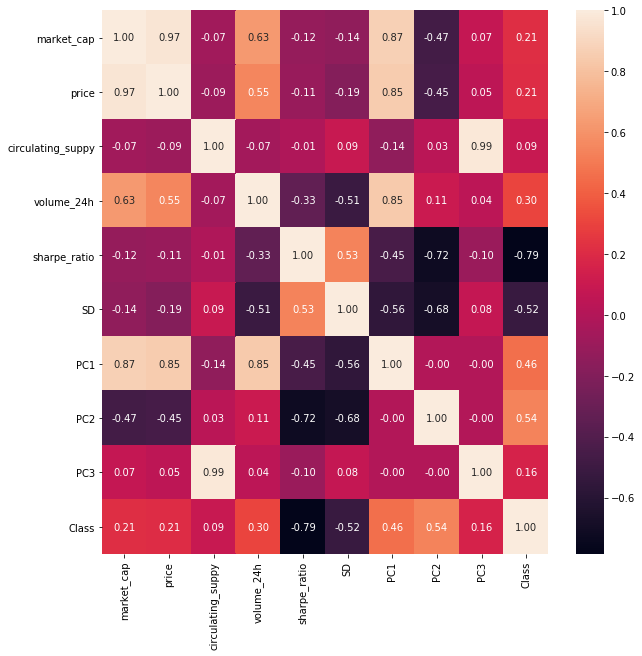

In [266]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt


def plot_correlation(data):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    # init figure size
    rcParams['figure.figsize'] = 10, 10
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()
    fig.savefig('corr.png')

# load your data 
data  = clustered_df

# plot correlation & densities
plot_correlation(data)

In [267]:
# Create a 3D-Scatter with the PCA data and the clusters
import plotly.express as px
fig = px.scatter_3d(
    clustered_df,
    x="market_cap",
    y="sharpe_ratio",
    z="volume_24h",
    hover_name='symbol',#need to add 
    hover_data=["sharpe_ratio"],
    color="Class",
    symbol="Class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

### Clustering Crytocurrencies Using K-Means

In [268]:
from sklearn.cluster import KMeans
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range ok k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_crypto_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

In [269]:
# Initialize the K-Means model
model = KMeans(n_clusters=2, random_state=5)
# Fit the model
model.fit(df_crypto_pca)
# Predict clusters
predictions = model.predict(df_crypto_pca)
# print(predictions)

In [270]:
# Create a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df_k = clustered_df
# crypto_pca["CoinName"] = crypto_names
clustered_df_k["class"] = model.labels_

clustered_df_k = crypto_features_df.join(df_crypto_pca)
clustered_df_k['symbol']=clustered_df.index.values
clustered_df_k.head()


,market_cap,price,circulating_suppy,volume_24h,sharpe_ratio,SD,PC1,PC2,PC3,Class,symbol
ticker,,,,,,,,,,,
BTC/USD,1.687175e+11,9152.150000,1.843474e+07,1.576724e+10,0.828805,0.736951,7.339800,-3.089542,0.374235,1,BTC/USD
ETH/USD,2.610287e+10,233.510000,1.117848e+08,6.188149e+09,1.309633,0.936119,0.656681,-0.348381,-0.316678,1,ETH/USD
USDT/USD,9.194532e+09,1.000000,9.194532e+09,2.058645e+10,0.142830,0.025620,3.450363,3.216337,0.092241,1,USDT/USD
XRP/USD,8.576460e+09,0.193784,4.425783e+10,1.059298e+09,0.406411,0.757499,0.209206,1.187733,1.451116,1,XRP/USD
BCH/USD,4.142723e+09,224.370000,1.846380e+07,1.145655e+09,0.673800,1.024802,-0.071910,0.345149,-0.281845,1,BCH/USD


In [271]:
# Scatter Plot
clustered_df_k.hvplot.scatter(x="sharpe_ratio", y="market_cap", by="Class",hover_cols=["symbol"])

:NdOverlay   [Class]
   :Scatter   [sharpe_ratio]   (market_cap,symbol)

In [275]:
#3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="market_cap",
    y="sharpe_ratio",
    z="volume_24h",
    hover_name="symbol",
    hover_data=["sharpe_ratio"],
    color="class",
    symbol="class",
#     size="TotalCoinSupply",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

## Clustering Crytocurrencies Using Spectral Clustering 

In [276]:
select_features_df = crypto_features_df
select_features_df.head()

,market_cap,price,circulating_suppy,volume_24h,sharpe_ratio,SD
ticker,,,,,,
BTC/USD,1.687175e+11,9152.150000,1.843474e+07,1.576724e+10,0.828805,0.736951
ETH/USD,2.610287e+10,233.510000,1.117848e+08,6.188149e+09,1.309633,0.936119
USDT/USD,9.194532e+09,1.000000,9.194532e+09,2.058645e+10,0.142830,0.025620
XRP/USD,8.576460e+09,0.193784,4.425783e+10,1.059298e+09,0.406411,0.757499
BCH/USD,4.142723e+09,224.370000,1.846380e+07,1.145655e+09,0.673800,1.024802


In [277]:
# Standardize data
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
crypto_scaled_3f = StandardScaler().fit_transform(select_features_df)
print(crypto_df_scaled[0:1])

[[ 5.22079297  5.18975895 -0.37576786  3.00663522 -0.54134648 -0.58940163]]


In [278]:
# Initialize the Spectral Clustering model
model = SpectralClustering(n_clusters=3, random_state=5)

In [279]:
# Fit the model
model.fit(crypto_scaled_3f)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=3, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=5)

In [280]:
# Predict clusters
predictions = model.fit_predict(crypto_scaled_3f)
print(predictions)

[1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1]


In [281]:
#DataFrame including predicted clusters and cryptocurrencies features
clustered_df_3f=select_features_df
clustered_df_3f["Class"] = model.labels_
clustered_df_3f['symbol']=clustered_df.index.values
clustered_df_3f.head()

,market_cap,price,circulating_suppy,volume_24h,sharpe_ratio,SD,Class,symbol
ticker,,,,,,,,
BTC/USD,1.687175e+11,9152.150000,1.843474e+07,1.576724e+10,0.828805,0.736951,1,BTC/USD
ETH/USD,2.610287e+10,233.510000,1.117848e+08,6.188149e+09,1.309633,0.936119,1,ETH/USD
USDT/USD,9.194532e+09,1.000000,9.194532e+09,2.058645e+10,0.142830,0.025620,2,USDT/USD
XRP/USD,8.576460e+09,0.193784,4.425783e+10,1.059298e+09,0.406411,0.757499,1,XRP/USD
BCH/USD,4.142723e+09,224.370000,1.846380e+07,1.145655e+09,0.673800,1.024802,1,BCH/USD


In [282]:
# Scatter Plot
clustered_df_3f.hvplot.scatter(x="sharpe_ratio", y="market_cap", by="Class",hover_cols=["symbol"])

:NdOverlay   [Class]
   :Scatter   [sharpe_ratio]   (market_cap,symbol)

In [283]:
#3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df_3f,
    x="market_cap",
    y="sharpe_ratio",
    z="volume_24h",
    hover_name='symbol',#need to add 
    hover_data=["sharpe_ratio"],
    color="Class",
    symbol="Class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [284]:
# CSV file 
csv_df=clustered_df_3f.filter(items=['market_cap', 'Class'])
csv_df.to_csv('Classification_v2.csv', index=True)

## Predicting Crypto Classes

In [355]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [356]:
test_df=cm_crypto_features_df.copy()
test_df.set_index('Symbol', inplace=True)
test_df.head()

,market_cap,price,circulating_suppy,volume_24h,ticker
Symbol,,,,,
BTC,1.687175e+11,9152.150000,1.843474e+07,1.576724e+10,BTC/USD
ETH,2.610287e+10,233.510000,1.117848e+08,6.188149e+09,ETH/USD
USDT,9.194532e+09,1.000000,9.194532e+09,2.058645e+10,USDT/USD
XRP,8.576460e+09,0.193784,4.425783e+10,1.059298e+09,XRP/USD
BCH,4.142723e+09,224.370000,1.846380e+07,1.145655e+09,BCH/USD


In [357]:
scaled_df=test_df.iloc[:,0:4].copy()
col=scaled_df.columns.to_list()

min_max_scaler = MinMaxScaler()
scaled_df[col] = min_max_scaler.fit_transform(scaled_df[col])
scaled_df.head()

,market_cap,price,circulating_suppy,volume_24h
Symbol,,,,
BTC,1.000000,1.000000,0.000058,0.765903
ETH,0.154624,0.025514,0.000355,0.300591
USDT,0.054397,0.000109,0.029202,1.000000
XRP,0.050733,0.000021,0.140563,0.051453
BCH,0.024451,0.024516,0.000059,0.055648


In [358]:
pca = PCA(n_components=3)
test_pca = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=test_pca, columns=["PC1", "PC2","PC3"],index=scaled_df.index)

In [359]:
scaled_data=scaled_df.copy()
scaled_data['PC1']=pca_df['PC1']
scaled_data['PC2']=pca_df['PC2']
scaled_data['PC3']=pca_df['PC3']

In [360]:
from sklearn.cluster import SpectralClustering, KMeans,MeanShift,AffinityPropagation

In [361]:
#kmeans
test_kmean=scaled_data.copy()
kmeans_raw = KMeans(n_clusters=2, random_state=0).fit(scaled_df)
test_kmean['raw_cluster']=kmeans_raw.labels_
kmeans_pca = KMeans(n_clusters=2, random_state=0).fit(test_pca)
test_kmean['pca_cluster']=kmeans_pca.labels_
test_kmean['raw_cluster'].value_counts()

1    198
0      2
Name: raw_cluster, dtype: int64

In [362]:
test_kmean['pca_cluster'].value_counts()

1    198
0      2
Name: pca_cluster, dtype: int64

In [363]:
fig = px.scatter_3d(
    test_kmean,
    x="market_cap",
    y="circulating_suppy",
    z="volume_24h",
    hover_name=test_kmean.index,
    hover_data=["price"],
    color="raw_cluster",
    symbol="raw_cluster",
#     size="TotalCoinSupply",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [364]:
fig = px.scatter_3d(
    test_kmean,
    x="market_cap",
    y="circulating_suppy",
    z="volume_24h",
    hover_name=test_kmean.index,
    hover_data=["price"],
    color="pca_cluster",
    symbol="pca_cluster",
#     size="TotalCoinSupply",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [365]:
X_raw=test_kmean.iloc[:,0:4]
X_pca=test_kmean.iloc[:,4:7]
y_raw=test_kmean.iloc[:,7:8]
y_pca=test_kmean.iloc[:,8:]

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, random_state=0, stratify=y_raw, shuffle=True)
lsvm = LinearSVC(random_state=0)
lsvm.fit(X_train, y_train)

y_pred = lsvm.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00         1
          1       0.98      1.00      0.00      0.99      0.00      0.00        49

avg / total       0.96      0.98      0.02      0.97      0.00      0.00        50



C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [366]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, random_state=0, stratify=y_raw, shuffle=True)
lsvm = LinearSVC(random_state=0)
lsvm.fit(X_train, y_train)

y_pred = lsvm.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00         1
          1       0.98      1.00      0.00      0.99      0.00      0.00        49

avg / total       0.96      0.98      0.02      0.97      0.00      0.00        50



C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [367]:
#spectral shift
test_spectral=scaled_data.copy()
spectral_raw = SpectralClustering(n_clusters=2, random_state=0).fit(scaled_df)
test_spectral['raw_cluster']=spectral_raw.labels_
spectral_pca = SpectralClustering(n_clusters=2, random_state=0).fit(test_pca)
test_spectral['pca_cluster']=spectral_pca.labels_
test_spectral['raw_cluster'].value_counts()

0    196
1      4
Name: raw_cluster, dtype: int64

In [368]:
test_spectral['pca_cluster'].value_counts()

0    196
1      4
Name: pca_cluster, dtype: int64

In [369]:
# from pathlib import Path
# test_df['Class']=spectral_raw.labels_
# data=Path('./chat_bot/Classification.csv')
# test_df.to_csv(data, index=True)

In [370]:
fig = px.scatter_3d(
    test_spectral,
    x="market_cap",
    y="circulating_suppy",
    z="volume_24h",
    hover_name=test_spectral.index,
    hover_data=["price"],
    color="raw_cluster",
    symbol="raw_cluster",
#     size="TotalCoinSupply",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()


In [371]:
fig = px.scatter_3d(
    test_spectral,
    x="market_cap",
    y="circulating_suppy",
    z="volume_24h",
    hover_name=test_spectral.index,
    hover_data=["price"],
    color="pca_cluster",
    symbol="pca_cluster",
#     size="TotalCoinSupply",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [399]:
X_raw=test_spectral.iloc[:,0:4]
X_pca=test_spectral.iloc[:,4:7]
y_raw=test_spectral.iloc[:,7:8]
y_pca=test_spectral.iloc[:,8:]

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, random_state=0, shuffle=True)

lsvm = LinearSVC(random_state=0)
lsvm.fit(X_train, y_train)

y_pred = lsvm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [400]:
acc_score = accuracy_score(y_test, y_pred)

print("Confusion Matrix")
print(cm)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix
[[50]]
Accuracy Score : 1.0
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [401]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, random_state=0, shuffle=True)

lsvm = LinearSVC(random_state=0)
lsvm.fit(X_train, y_train)

y_pred = lsvm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)


acc_score = accuracy_score(y_test, y_pred)

print("Confusion Matrix")
print(cm)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix
[[50]]
Accuracy Score : 1.0
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [402]:
#mean_shift
test_mean=scaled_data.copy()
mean_raw = MeanShift().fit(scaled_df)
test_mean['raw_cluster']=mean_raw.labels_
mean_pca = MeanShift().fit(test_pca)
test_mean['pca_cluster']=mean_pca.labels_

In [403]:
test_mean['raw_cluster'].value_counts()

0     183
1       6
5       2
11      1
10      1
9       1
8       1
7       1
6       1
4       1
3       1
2       1
Name: raw_cluster, dtype: int64

In [404]:
test_mean['pca_cluster'].value_counts()

0     183
1       6
6       2
11      1
10      1
9       1
8       1
7       1
5       1
4       1
3       1
2       1
Name: pca_cluster, dtype: int64

In [405]:
fig = px.scatter_3d(
    test_mean,
    x="market_cap",
    y="circulating_suppy",
    z="volume_24h",
    hover_name=test_mean.index,
    hover_data=["price"],
    color="raw_cluster",
    symbol="raw_cluster",
#     size="TotalCoinSupply",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [406]:
fig = px.scatter_3d(
    test_mean,
    x="market_cap",
    y="circulating_suppy",
    z="volume_24h",
    hover_name=test_mean.index,
    hover_data=["price"],
    color="pca_cluster",
    symbol="pca_cluster",
#     size="TotalCoinSupply",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [407]:
test_df2=crypto_features_df.copy()
test_df2=crypto_features_df.drop(columns=['symbol'],axis=1)
test_df2.head()

,market_cap,price,circulating_suppy,volume_24h,sharpe_ratio,SD,Class
ticker,,,,,,,
BTC/USD,1.687175e+11,9152.150000,1.843474e+07,1.576724e+10,0.828805,0.736951,1
ETH/USD,2.610287e+10,233.510000,1.117848e+08,6.188149e+09,1.309633,0.936119,1
USDT/USD,9.194532e+09,1.000000,9.194532e+09,2.058645e+10,0.142830,0.025620,2
XRP/USD,8.576460e+09,0.193784,4.425783e+10,1.059298e+09,0.406411,0.757499,1
BCH/USD,4.142723e+09,224.370000,1.846380e+07,1.145655e+09,0.673800,1.024802,1


In [408]:
scaled_df2=test_df2.copy()
col=scaled_df2.columns.to_list()
min_max=MinMaxScaler()
scaled_df2[col] = min_max.fit_transform(test_df2[col])
# stand_scaler = StandardScaler()
# scaled_df2[col] = stand_scaler.fit_transform(test_df2[col])
scaled_df2.head()
pca = PCA(n_components=3)
test_pca2 = pca.fit_transform(scaled_df2)
pca_df2 = pd.DataFrame(data=test_pca2, columns=["PC1", "PC2","PC3"],index=scaled_df2.index)
scaled_data2=scaled_df2.copy()
scaled_data2['PC1']=pca_df2['PC1']
scaled_data2['PC2']=pca_df2['PC2']
scaled_data2['PC3']=pca_df2['PC3']

In [409]:
#spectral shift
test_spectral2=scaled_data2.copy()
spectral_raw = SpectralClustering(n_clusters=2, random_state=0).fit(scaled_df2)
test_spectral2['raw_cluster']=spectral_raw.labels_
spectral_pca = SpectralClustering(n_clusters=2, random_state=0).fit(pca_df2)
test_spectral2['pca_cluster']=spectral_pca.labels_
test_spectral2

,market_cap,price,circulating_suppy,volume_24h,sharpe_ratio,SD,Class,PC1,PC2,PC3,raw_cluster,pca_cluster
ticker,,,,,,,,,,,,
BTC/USD,1.000000,1.000000e+00,0.000147,0.765902,0.292142,0.570573,0.5,1.163654,0.909690,-0.146808,1,1
ETH/USD,0.154568,2.551391e-02,0.000891,0.300589,0.496915,0.730329,0.5,0.111841,0.149349,-0.005262,0,0
USDT/USD,0.054334,1.089421e-04,0.073301,1.000000,0.000000,0.000000,1.0,1.071402,-0.243573,0.431728,1,1
XRP/USD,0.050670,2.085172e-05,0.352835,0.051450,0.112253,0.587055,0.5,0.147701,-0.258359,0.240532,0,0
BCH/USD,0.024386,2.451524e-02,0.000147,0.055645,0.226128,0.801463,0.5,0.013586,-0.084495,0.005644,0,0
ADA/USD,0.019181,1.343663e-05,0.206697,0.020470,0.889723,0.782114,0.5,-0.311029,0.228128,0.032259,0,0
LINK/USD,0.017494,9.295146e-04,0.002792,0.053610,1.000000,0.805348,0.5,-0.339819,0.314822,-0.123908,0,0
LTC/USD,0.016043,4.594228e-03,0.000518,0.076251,0.144983,0.682218,0.5,0.111419,-0.189265,0.004396,0,0
EOS/USD,0.013709,2.739307e-04,0.007438,0.063628,0.134535,0.707980,0.5,0.093220,-0.189604,0.014677,0,0


In [410]:
test_spectral2['raw_cluster'].value_counts()

0    25
1     4
Name: raw_cluster, dtype: int64

In [411]:
test_spectral2['pca_cluster'].value_counts()

0    25
1     4
Name: pca_cluster, dtype: int64

In [412]:
from pathlib import Path
test_df2['Class']=spectral_raw.labels_
data=Path('./Classification.csv')
test_df2.to_csv(data, index=True)

In [413]:
fig = px.scatter_3d(
    test_spectral2,
    x="market_cap",
    y="circulating_suppy",
    z="sharpe_ratio",
    hover_name=test_spectral2.index,
    hover_data=["price"],
    color="raw_cluster",
    symbol="raw_cluster",
#     size="TotalCoinSupply",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [414]:
fig = px.scatter_3d(
    test_spectral2,
    x="market_cap",
    y="circulating_suppy",
    z="sharpe_ratio",
    hover_name=test_spectral2.index,
    hover_data=["price"],
    color="pca_cluster",
    symbol="pca_cluster",
#     size="TotalCoinSupply",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()